# Notebook about supervised learning (for the Ising model)
## MLQMB - Toulouse Summer School

This notebook contains code to generate classical 2D Ising model data (using the Wolff cluster algorithm), and examples of finding the finite temperature phase transition using machine learning methods. For the purpose of keeping this running quickly, this notebook focuses on the idea rather than on accuracy (so small networks, small system size, etc)

### Install and import all the required packages

In [ ]:
!pip install flax

In [ ]:
import numpy as np

from collections import deque
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

# To measure the time it takes to train a network
import time

# Everything we need from JAX
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.scipy.special import logsumexp # Computes the log of the sum of exponentials of input elements.
from jax.experimental import optimizers

# Flax module for deep learning models
import flax.linen as nn

# The key for our random number generator, we need this because JAX will distribute the calculation
key = random.PRNGKey(0)

### The Wolff cluster update algorithm for the Ising model

In [ ]:
class WolffMonteCarlo:
    """ Wolff Monte Carlo simulator for the Ising model."""
    def __init__(self, L, T, method=None):
        self._L = L
        self._T = T
        self._K = 2. / T
        self._method = method

        # set up initial state
        self._state = np.random.randint(0, 2, size=[L, L])

    @property
    def L(self):
        return self._L

    @property
    def T(self):
        return self._T

    @property
    def K(self):
        return self._K

    @property
    def state(self):
        return self._state

    def probability_add_bond(self, x1, y1, x2, y2, state):
        """The probability for adding a bond."""
        E = 1.0 if state[x1, y1] == state[x2, y2] else 0.0
        return 1.0 - np.exp(-self.K * E)

    def set_T(self, T):
        self._T = T
        self._K = 2. / T

    def wolff_iterative(self, state):
        """ Iterative Wolff Algorithm 
            This algorithm uses a doubly ended queue (deque), which provides O(1) 
            operations for adding and removing items from both ends of a list. 
        """
        
        # Convenient lists for indexing
        # Below, we'll use these to get the left (or 'above', etc) neighbors of a site.
        # Includes periodic boundaries! Another option would be to replace
        #    left[x1]   by   (x1 - 1) % L
        # but that does an addition and a module every step.
        left = [self.L - 1] + list(range(self.L - 1))
        right = list(range(1, self.L)) + [0]
        
        # Book-keeping containers
        sites_to_consider = deque()
        sites_to_flip = set()
        bonds_considered = set()

        # Initial queue of sites to consider, just consisting of a single (x,y) location
        sites_to_consider.append((
            np.random.randint(0, self.L),
            np.random.randint(0, self.L)
        ))

        # As long as there are sites to consider
        while sites_to_consider:
            # Pick a new site to consider from the queue, either using
            # breadth first or depth first
            if self._method == "BFS":
                x1, y1 = sites_to_consider.popleft()
            if self._method == "DFS":
                x1, y1 = sites_to_consider.pop()

            # For the neighbors of this site
            for x2, y2 in zip([left[x1], right[x1], x1, x1],
                              [y1, y1, left[y1], right[y1]]):
                
                # Check if we have not already considered this pair
                if not (x1, y1, x2, y2) in bonds_considered:
                    # Add the pair so that we don't flip it twice
                    bonds_considered.add((x1, y1, x2, y2))
                    bonds_considered.add((x2, y2, x1, y1))

                    if np.random.rand() < self.probability_add_bond(x1, y1, x2, y2, state):
                        sites_to_consider.append((x2, y2))
                        sites_to_flip.add((x1, y1))
                        sites_to_flip.add((x2, y2))
                        
        return sites_to_flip

    def step(self):
        """Use Wolff and perform update."""

        # Get a list of sites to flip...
        to_flip = self.wolff_iterative(self._state)

        # ...and flip them
        for (x, y) in to_flip:
            self._state[x, y] = 1 - self._state[x, y]

        # Return the list of the flipped sites
        return to_flip


In [ ]:
def generate_Ising_configurations(L, numSamplesPerT, Ts, equilibrationSteps=100):
    ''' Generates snapshots for the 2D Ising model for a given set of temperatures

    Samples are generated using Wolff cluster updates.

    Parameters:

        * `L`: Linear size of the system
        * `numSamplesPerT`: Number of samples to generate per temperature
        * `Ts`: List of temperatures
        * `equilibrationSteps`: Number of equilibration steps

    Returns:
        * A dictionary with the sampled configurations for each temperature

    '''

    # Initialize a new simulator
    sim = WolffMonteCarlo(L=L, T=5, method="DFS")

    all_data = {}

    # Loop over a fixed set of temperatures
    for T in Ts:
        print("Generating samples for L = %d at T = %.3f"%(L,T))

        # Set temperature
        sim.set_T(T)

        # For storing all of the configurations
        snapshots = []
        for s in range(numSamplesPerT + equilibrationSteps):

            # Keep flipping sites, until we flipped at least L^2 of them
            c = 0
            while c < 1:
                to_flip = sim.step()
                c = c + len(to_flip) / L / L

            # The first half of the flips are to equilibrate, the rest are samples
            if s >= equilibrationSteps:
                snapshots.append(np.array(-1 + 2 * sim.state.reshape(-1)))


        all_data['%.3f'%(T)] = np.array(snapshots)

    return all_data

## Generate Ising model data

In [ ]:
# The temperatures that we are going to generate samples at
Ts = np.arange(1.95, 0.04, -0.1) * 2.27

# For a few different system sizes, store the data in a dictionary with L as key
all_data = generate_Ising_configurations(10, 1000, Ts)

Generating samples for L = 10 at T = 4.426
Generating samples for L = 10 at T = 4.199
Generating samples for L = 10 at T = 3.972
Generating samples for L = 10 at T = 3.745
Generating samples for L = 10 at T = 3.518
Generating samples for L = 10 at T = 3.291
Generating samples for L = 10 at T = 3.064
Generating samples for L = 10 at T = 2.837
Generating samples for L = 10 at T = 2.610
Generating samples for L = 10 at T = 2.383
Generating samples for L = 10 at T = 2.156
Generating samples for L = 10 at T = 1.929
Generating samples for L = 10 at T = 1.702
Generating samples for L = 10 at T = 1.475
Generating samples for L = 10 at T = 1.248
Generating samples for L = 10 at T = 1.021
Generating samples for L = 10 at T = 0.794
Generating samples for L = 10 at T = 0.567
Generating samples for L = 10 at T = 0.340
Generating samples for L = 10 at T = 0.113


## Split the data into training/testing/validation sets

In [ ]:
def split_training_data(all_data, Ts, Tc=2.7, train_fraction=0.8):
    # Lists to store the raw data
    raw_T = []
    raw_x = []
    raw_y = [] 
    
    for T in Ts:      
        raw_x.append(all_data['%.3f'%(T)])
        n = len(all_data['%.3f'%(T)])
        label = [1,0] if T < Tc else [0,1]
        raw_y.append(np.array([label] * n))
        raw_T.append(np.array([T]*n))
        
    raw_T = np.concatenate(raw_T)
    raw_x = np.concatenate(raw_x, axis=0)
    raw_y = np.concatenate(raw_y, axis=0)
    
    # Shuffle
    indices = np.random.permutation(len(raw_x))
    all_T = raw_T[indices]
    all_x = raw_x[indices]
    all_y = raw_y[indices]

    # Split into train and test sets
    train_split = int(train_fraction * len(all_x))
    train_T = jnp.array(all_T[:train_split])
    train_x = jnp.array(all_x[:train_split])
    train_y = jnp.array(all_y[:train_split])
    test_T = jnp.array(all_T[train_split:])
    test_x = jnp.array(all_x[train_split:])
    test_y = jnp.array(all_y[train_split:])
    
    return [raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y]

## Visualize some of the Ising model snapshots

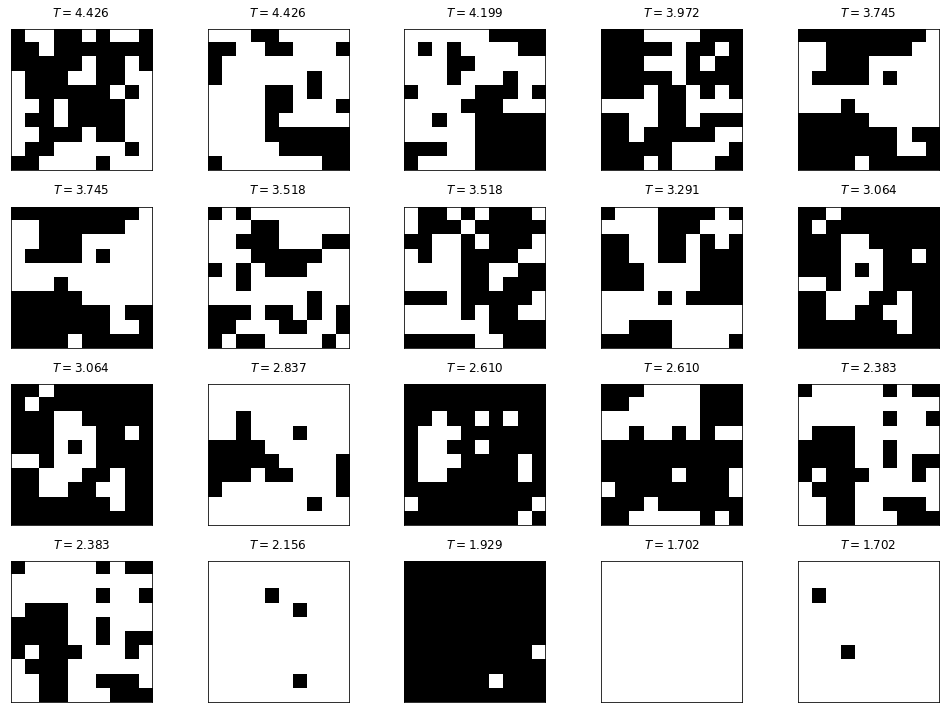

In [ ]:
[raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y] = split_training_data(all_data,Ts)

fig, ax = plt.subplots(4,5, figsize=(14,10))
for i in range(4):
    for j in range(5):
        ax[i,j].matshow(np.reshape(raw_x[(4*i + j)*800], (10,10)), cmap='Greys')
        ax[i,j].set_title("$T = %.3f$"%raw_T[(4*i + j)*800])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
fig.tight_layout()

# Learning the transition (the JAX version)

## Define the neural network

In [ ]:
from typing import Sequence

class MyNet(nn.Module):
    layers: Sequence[int] # A tuple that contains the widths of all layers follwing the input layer
    
    @nn.compact
    def __call__(self, x):

        a = x.ravel() # flatten the input

        # Evaluate network layer by layer
        for width in self.layers[:-1]:
            # Apply a the Dense layer with given width followed by the non-linearity
            a = nn.relu(nn.Dense(width)(a))
          
        a = nn.Dense(self.layers[-1])(a)
        
        # Return activations of the output layer
        return a - logsumexp(a)
    
# Initialize a new network (or rather its parameters)
layer_sizes = [100, 64, 32, 2]
net = MyNet(layers=layer_sizes)

In [ ]:
# Make a batched `predict` function
predict = jax.vmap(lambda p, x: net.apply(p,x), in_axes=(None, 0), out_axes=0)

### The loss function

In [ ]:
def loss(params, images, targets):
    preds = predict(params, images)
    return -jnp.mean(preds * targets)

### The optimizer

In [ ]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)

@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

### The training loop

In [ ]:
def accuracy(params, images, targets):
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def train(train_x, train_y, test_x, test_y, num_epochs, batch_size, opt_state):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_x, train_y)
    test_acc = accuracy(params, test_x, test_y)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Divide into batches
    num_batches = len(train_x) // batch_size

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Shuffle data
        indices = np.random.permutation(len(train_x))
        batch_indices = jnp.split(indices[:num_batches*batch_size], batch_size)
        
        for b in range(len(batch_indices)):
            x = train_x[batch_indices[b]]
            y = train_y[batch_indices[b]]
            
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_x, train_y)
        test_acc = accuracy(params, test_x, test_y)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | Time: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))

        
    return train_loss, log_acc_train, log_acc_test, params

## Pick the temperatures to train on, and initialize the network

In [ ]:
# Pick only the Ts at the beginning and at the end, and construct a dataset
train_Ts = list(Ts[:4]) + list(Ts[-4:])
[raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y] = split_training_data(all_data, train_Ts)

# Initialize a new network (or rather its parameters)
params = MyNet(layers=layer_sizes).init(key, train_x[0])

# Initialize the optimizer
opt_state = opt_init(params)

### Train and plot the loss :)

Epoch 1 | Time: 0.27 | Train A: 1.000 | Test A: 1.000
Epoch 2 | Time: 0.12 | Train A: 1.000 | Test A: 1.000
Epoch 3 | Time: 0.12 | Train A: 1.000 | Test A: 1.000
Epoch 4 | Time: 0.12 | Train A: 1.000 | Test A: 1.000
Epoch 5 | Time: 0.13 | Train A: 1.000 | Test A: 1.000


Text(0, 0.5, 'Loss')

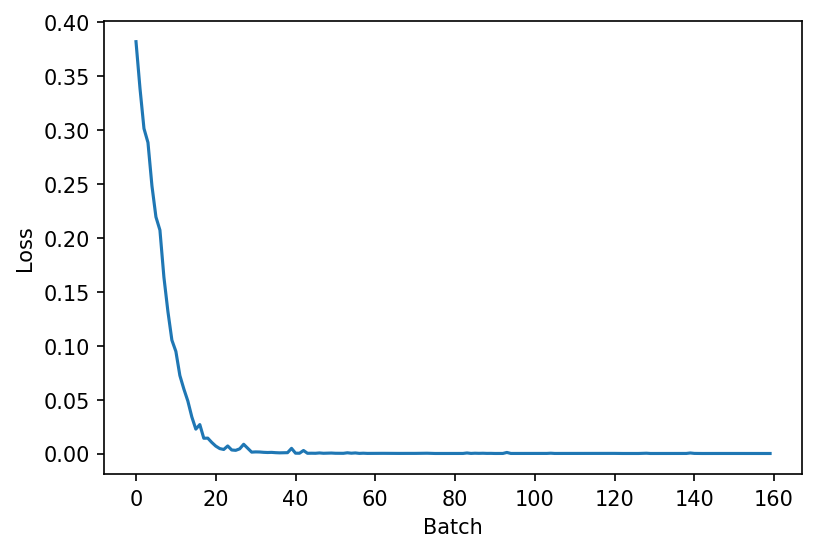

In [ ]:
train_loss, train_log, test_log, params = train(train_x, train_y, test_x, test_y, 5, 32, opt_state)

fig, ax = plt.subplots(dpi=150)
ax.plot(train_loss)
ax.set_xlabel("Batch")
ax.set_ylabel("Loss")

## Now predict on the other intermediate temperatures

In [ ]:
# For every temperature, get the averaged prediction
predictions = []
for T in Ts:
    x = all_data['%.3f'%T]#['x']
    p = jnp.exp( predict(params, x) )  # Exponentiate it to go back to the [0,1] range for nicer plotting
    p = jnp.mean( p, axis=0 )
    predictions.append(p)

Text(0, 0.5, 'Predictions')

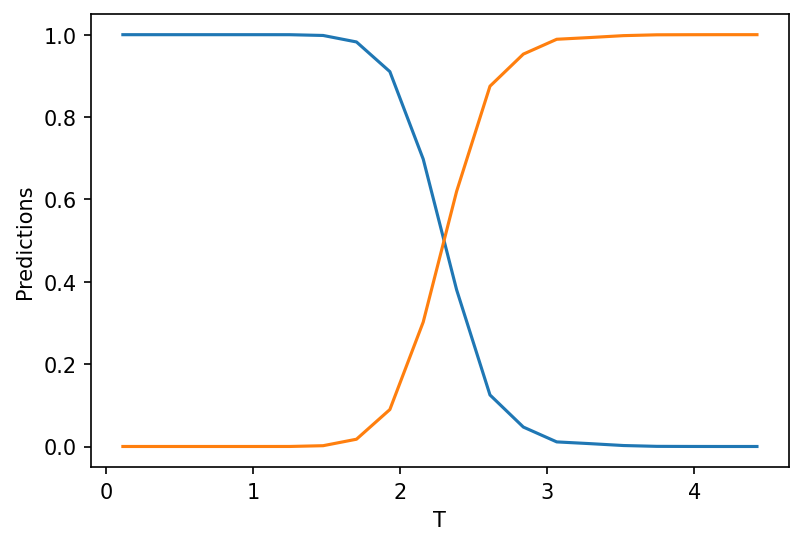

In [ ]:
fig, ax = plt.subplots(dpi=150)
ax.plot( Ts, predictions )
ax.set_xlabel("T")
ax.set_ylabel("Predictions")

### Challenges and other ideas
* Fit a sigmoid to the outputs to extract the crossing point (=Tc)
* See how the crossing point depends on:
    * The (width of the) regions in which you train
    * The network architecture
    * Size of the data (instead of 10x10 snapshots)   
* Convert to use a Flax model

# Learning By Confusion

In [ ]:
def train_with_guess(Ts, Tc_guess):
    [raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y] = split_training_data(all_data, Ts, Tc=Tc_guess, train_fraction=0.9)
    
    # Initialize a new network (or rather its parameters)
    params = MyNet(layers=layer_sizes).init(key, train_x[0])

    # Initialize the optimizer
    opt_state = opt_init(params)

    train_loss, train_log, test_log, params = train(train_x, train_y, test_x, test_y, 5, 16, opt_state)
    
    return train_log

In [ ]:
W_over_time = {}
for guess in np.linspace(Ts[0], Ts[-1], 10):
    print("Training at guess %.3f"%guess)
    accuracy_vs_epoch = train_with_guess(Ts, guess)
    W_over_time[guess] = accuracy_vs_epoch
    print("\t Final accuracy: %.3f"%accuracy_vs_epoch[-1])

Training at guess 4.426
Epoch 1 | Time: 1.64 | Train A: 0.950 | Test A: 0.948
Epoch 2 | Time: 0.15 | Train A: 0.950 | Test A: 0.948
Epoch 3 | Time: 0.15 | Train A: 0.950 | Test A: 0.948
Epoch 4 | Time: 0.15 | Train A: 0.950 | Test A: 0.948
Epoch 5 | Time: 0.15 | Train A: 0.950 | Test A: 0.948
	 Final accuracy: 0.950
Training at guess 3.947
Epoch 1 | Time: 0.14 | Train A: 0.849 | Test A: 0.855
Epoch 2 | Time: 0.13 | Train A: 0.851 | Test A: 0.854
Epoch 3 | Time: 0.15 | Train A: 0.858 | Test A: 0.859
Epoch 4 | Time: 0.14 | Train A: 0.863 | Test A: 0.861
Epoch 5 | Time: 0.15 | Train A: 0.866 | Test A: 0.857
	 Final accuracy: 0.866
Training at guess 3.468
Epoch 1 | Time: 0.14 | Train A: 0.857 | Test A: 0.875
Epoch 2 | Time: 0.15 | Train A: 0.863 | Test A: 0.878
Epoch 3 | Time: 0.15 | Train A: 0.867 | Test A: 0.878
Epoch 4 | Time: 0.15 | Train A: 0.872 | Test A: 0.880
Epoch 5 | Time: 0.14 | Train A: 0.876 | Test A: 0.883
	 Final accuracy: 0.876
Training at guess 2.989
Epoch 1 | Time: 0.16 |

Text(0, 0.5, 'Accuracy')

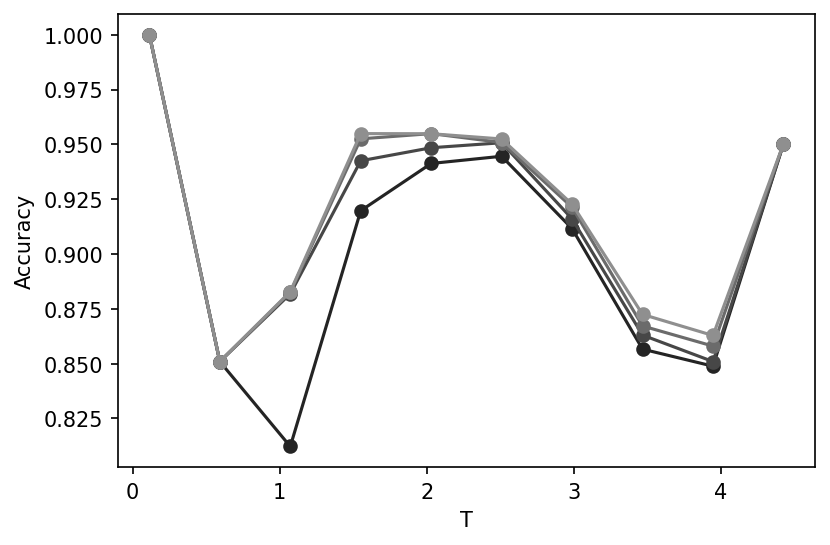

In [ ]:
fig, ax = plt.subplots(dpi=150)

guess_Ts = np.linspace(Ts[0], Ts[-1], 10)

for i in range(1,5):
    curve = [W_over_time[guess][i] for guess in guess_Ts]
    color = np.array([0.7, 0.7, 0.7])*i/5
    ax.plot( guess_Ts, curve, '-o', c=color )

ax.set_xlabel("T")
ax.set_ylabel("Accuracy")

## Challenges and other ideas
* Play with the hyperparameters to build intuition, see if you can get a clear W shape
* Increase the temperature resolution
* Increase the number of epochs trained for, you should be able to see the W become more flat -> why is this?


# Even bigger challenge
Implement "DCNs": https://arxiv.org/abs/1706.08111
(either using two actual NNs, or merging them back into one)
